In [13]:
import pandas as pd
import numpy as np

from math import sqrt
import random

import collections

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [15]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def katz_centrality(G, alpha=1, beta=1, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n, 1.0/len(G.nodes())) for n in G.nodes()]) 
    else: 
        x = nstart 

    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast, 0)
  
        # do the multiplication y^T = x^T A 
        for n in x.keys(): 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)

        # apply alpha and beta
        for n in x:
            x[n] = alpha * x[n] + beta[n]
            
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) # this should never be zero
        except ZeroDivisionError: 
            s = 1.0

        for n in x: 
            x[n] *= s 
            
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
        
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [16]:
# build interactome network
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
G.number_of_nodes(), G.number_of_edges()

(14465, 92064)

In [17]:
# get MMAF candidate genes list
candidates_MMAF_tmp = pd.read_pickle("./data/candidateGenesList_MMAF.p")
candidates_MMAF = [c for c in candidates_MMAF_tmp if c in G.nodes()]

In [18]:
# set parameters alpha and beta
alpha = 0.1
beta = 1

In [19]:
# get its neighbours
[n for n in G.neighbors('ENSG00000188738')] # --> ENSG00000146223

['ENSG00000146223']

### Get KC of ENSG00000188738 and its neighbour when ENSG00000188738 in candidates

In [20]:
# calculate KC for each node: ENSG00000188738 in candidates
beta_dict = dict([(n, beta*int(n in candidates_MMAF)) for n in G])
res = katz_centrality(G, alpha=alpha, beta=beta_dict)
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [21]:
# get more info about each node
d = {}

for n, kc in res_sorted.items():
    d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF, n)), (n in candidates_MMAF))

df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df[df['isCandidate'] == False].sort_values(by='KC', ascending=False)

,KC,degree,candidates in N,isCandidate
ENSG00000084652,1.004894e-02,81,3,False
ENSG00000150477,8.398653e-03,30,3,False
ENSG00000101004,7.464172e-03,103,2,False
ENSG00000223501,7.035128e-03,84,2,False
ENSG00000135249,6.783907e-03,88,2,False
...,...,...,...,...
ENSG00000080007,3.983152e-21,1,0,False
ENSG00000184735,3.983152e-21,1,0,False
ENSG00000198520,3.983152e-21,1,0,False
ENSG00000183044,3.983152e-21,1,0,False


In [22]:
df.loc['ENSG00000146223']

KC                 0.002559
degree                    8
candidates in N           1
isCandidate           False
Name: ENSG00000146223, dtype: object

### Get KC of ENSG00000188738 and its neighbour when ENSG00000188738 not in candidates

In [23]:
# remove one candidate ENSG00000188738 from candidate list
idx = candidates_MMAF.index('ENSG00000188738')
left_out = candidates_MMAF[idx]

candidates_MMAF_new = candidates_MMAF[:idx] + candidates_MMAF[idx+1:]

print(f"Removed gene {left_out} from candidates")
print(f"Info: degree: {G.degree(left_out)}, candidates in N: {len(candidates_in_neighbourhood(G, candidates_MMAF_new, left_out))}")

Removed gene ENSG00000188738 from candidates
Info: degree: 1, candidates in N: 0


In [24]:
# calculate KC for each node: ENSG00000188738 not in candidates
beta_dict = dict([(n, beta*int(n in candidates_MMAF_new)) for n in G])
res_new = katz_centrality(G, alpha=alpha, beta=beta_dict)
res_new_sorted = dict(sorted(res_new.items(), key=lambda v: v[1], reverse=True))

In [25]:
# get more info about each node
d = {}

for n, kc in res_new_sorted.items():
    d[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF_new, n)), (n in candidates_MMAF_new))

df_new = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df_new[df_new['isCandidate'] == False].sort_values(by='KC', ascending=False)

,KC,degree,candidates in N,isCandidate
ENSG00000084652,1.036455e-02,81,3,False
ENSG00000150477,8.632966e-03,30,3,False
ENSG00000101004,7.706761e-03,103,2,False
ENSG00000223501,7.268106e-03,84,2,False
ENSG00000135249,7.004876e-03,88,2,False
...,...,...,...,...
ENSG00000080007,7.052765e-23,1,0,False
ENSG00000184735,7.052765e-23,1,0,False
ENSG00000198520,7.052765e-23,1,0,False
ENSG00000183044,7.052765e-23,1,0,False


In [26]:
df_new.loc['ENSG00000146223']

KC                 0.000106
degree                    8
candidates in N           0
isCandidate           False
Name: ENSG00000146223, dtype: object

### Compare KC when ENSG00000188738 in candidate list vs not in candidate list

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'ENSG00000188738 not in candidate list')

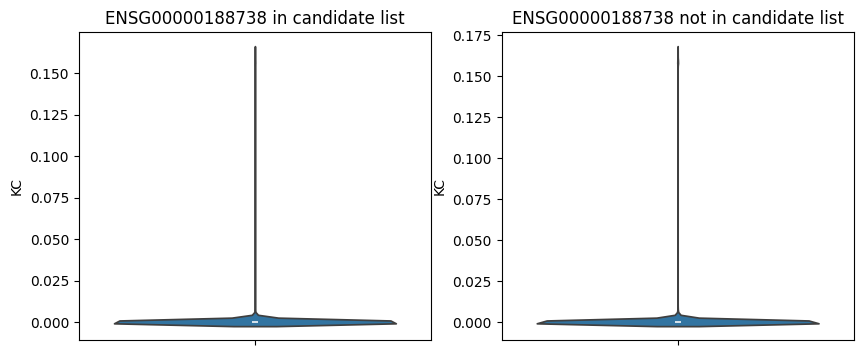

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.violinplot(data=df, y='KC', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")

sns.violinplot(data=df_new, y='KC', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")

Text(8.1, 0.00010556240500846862, 'ENSG00000146223, KC=0.00010556240500846862')

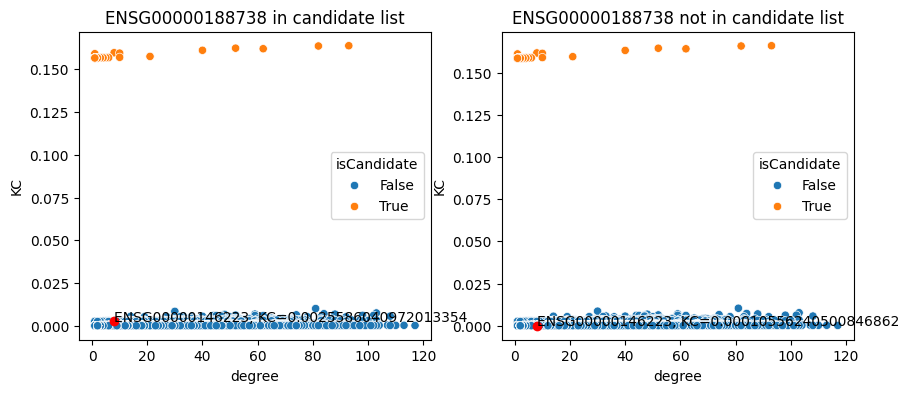

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=df, x='degree', y='KC', hue='isCandidate', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")
# plot neighbour of ENSG00000188738
x = df.loc['ENSG00000146223']['degree']
y = df.loc['ENSG00000146223']['KC']
ax[0].plot(x, y, 'ro')
ax[0].text(x+0.1, y, s=f"ENSG00000146223, KC={y}")

sns.scatterplot(data=df_new, x='degree', y='KC', hue='isCandidate', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")
# plot neighbour of ENSG00000188738
x = df_new.loc['ENSG00000146223']['degree']
y = df_new.loc['ENSG00000146223']['KC']
ax[1].plot(x, y, 'ro')
ax[1].text(x+0.1, y, s=f"ENSG00000146223, KC={y}")

Text(8.1, 0.00010556240500846862, 'ENSG00000146223, KC=0.00010556240500846862')

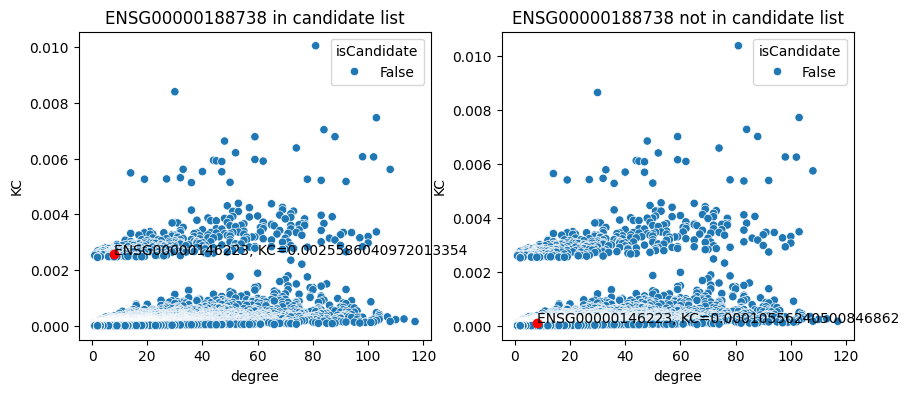

In [29]:
# plot only non candidates

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=df[df['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")
# plot neighbour of ENSG00000188738
x = df.loc['ENSG00000146223']['degree']
y = df.loc['ENSG00000146223']['KC']
ax[0].plot(x, y, 'ro')
ax[0].text(x+0.1, y, s=f"ENSG00000146223, KC={y}")

sns.scatterplot(data=df_new[df_new['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")
# plot neighbour of ENSG00000188738
x = df_new.loc['ENSG00000146223']['degree']
y = df_new.loc['ENSG00000146223']['KC']
ax[1].plot(x, y, 'ro')
ax[1].text(x+0.1, y, s=f"ENSG00000146223, KC={y}")

In [30]:
df[df['isCandidate'] == False].sort_values(by='KC', ascending=False)

,KC,degree,candidates in N,isCandidate
ENSG00000084652,1.004894e-02,81,3,False
ENSG00000150477,8.398653e-03,30,3,False
ENSG00000101004,7.464172e-03,103,2,False
ENSG00000223501,7.035128e-03,84,2,False
ENSG00000135249,6.783907e-03,88,2,False
...,...,...,...,...
ENSG00000080007,3.983152e-21,1,0,False
ENSG00000184735,3.983152e-21,1,0,False
ENSG00000198520,3.983152e-21,1,0,False
ENSG00000183044,3.983152e-21,1,0,False


Text(8.1, 0.00010556240500846862, 'ENSG00000146223, KC=0.00010556240500846862')

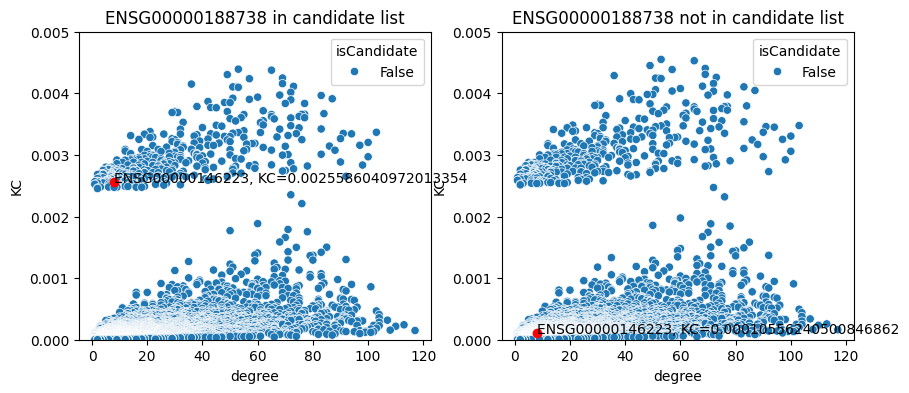

In [31]:
# plot only the lowest y limit

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.scatterplot(data=df[df['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")
# plot neighbour of ENSG00000188738
x = df.loc['ENSG00000146223']['degree']
y = df.loc['ENSG00000146223']['KC']
ax[0].plot(x, y, 'ro')
ax[0].set_ylim((0, 0.005))
ax[0].text(x+0.1, y, s=f"ENSG00000146223, KC={y}")

sns.scatterplot(data=df_new[df_new['isCandidate'] == False], x='degree', y='KC', hue='isCandidate', ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")
# plot neighbour of ENSG00000188738
x = df_new.loc['ENSG00000146223']['degree']
y = df_new.loc['ENSG00000146223']['KC']
ax[1].plot(x, y, 'ro')
ax[1].set_ylim((0, 0.005))
ax[1].text(x+0.1, y, s=f"ENSG00000146223, KC={y}")

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0, 0.00010556240500846862, 'ENSG00000146223, KC=0.00010556240500846862')

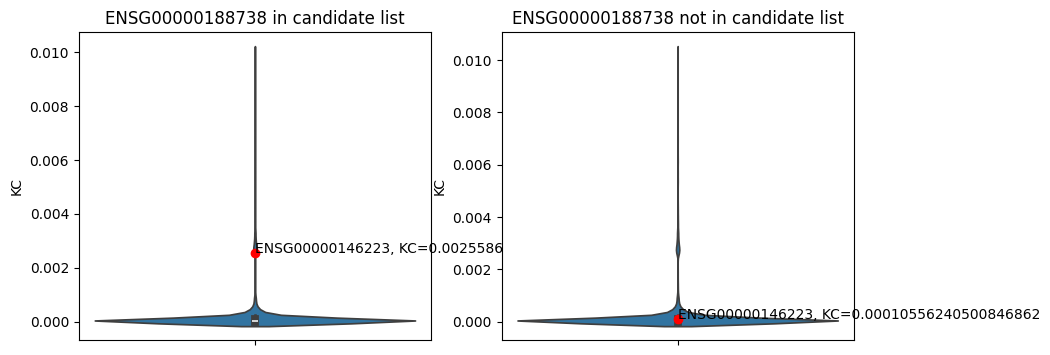

In [32]:
# plot distributions with KC of 

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.violinplot(data=df[(df['isCandidate'] == False) & (df['KC'] < 0.05)]['KC'], ax=ax[0])
ax[0].set_title("ENSG00000188738 in candidate list")
left_out_KC = df.loc['ENSG00000146223']['KC']
ax[0].plot(left_out_KC, 'or')
ax[0].text(0, left_out_KC, s=f"ENSG00000146223, KC={left_out_KC}")

sns.violinplot(data=df_new[(df_new['isCandidate'] == False) & (df_new['KC'] < 0.05)]['KC'], ax=ax[1])
ax[1].set_title("ENSG00000188738 not in candidate list")
left_out_KC = df_new.loc['ENSG00000146223']['KC']
ax[1].plot(left_out_KC, 'or')
ax[1].text(0, left_out_KC, s=f"ENSG00000146223, KC={left_out_KC}")

### Find the most affected non-candidate by ENSG00000188738  removal from candidate list

In [33]:
# calculate KC before and after removal for each node
df['KC after removal'] = df_new['KC']
df['DIFF KC'] = df['KC'] - df['KC after removal']
df.sort_values(by='DIFF KC', ascending=False, inplace=True)

In [61]:
# get the most affected gene
df.iloc[1:2, :]

,KC,degree,candidates in N,isCandidate,KC after removal,DIFF KC
ENSG00000146223,0.002559,8,1,False,0.000106,0.002453


In [36]:
# get top 10 most affected genes
df_top = df.iloc[1:11, :]

/tmp/ipykernel_11623/982863541.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(df_top.index, rotation=90)
/tmp/ipykernel_11623/982863541.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(df_top.index, rotation=90)


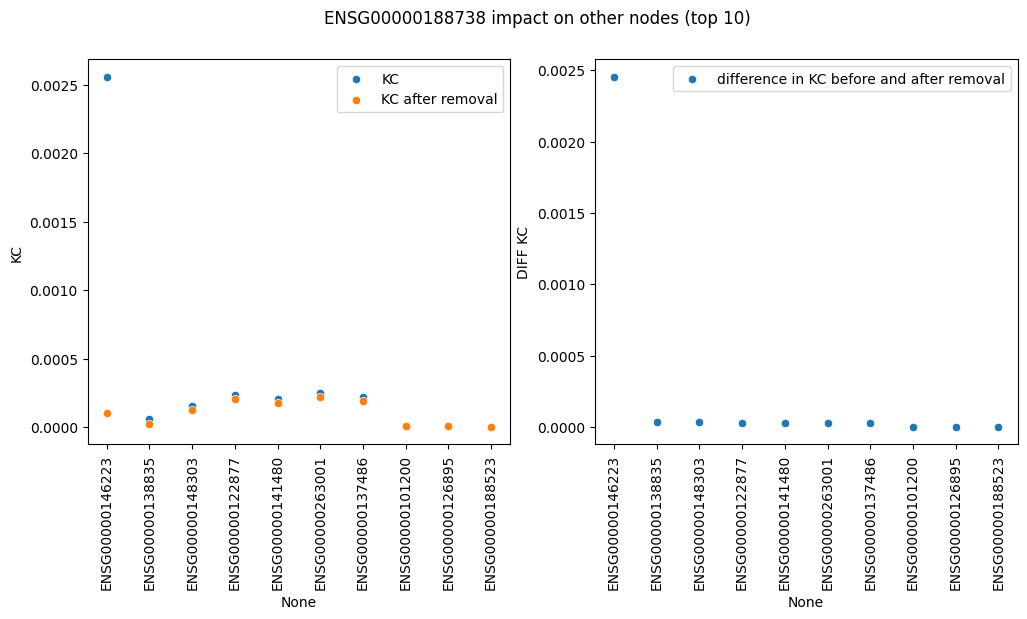

In [58]:
# plot top 10 most affected genes

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('ENSG00000188738 impact on other nodes (top 10)')

sns.scatterplot(data=df_top, x=df_top.index, y='KC', ax=ax[0], label='KC')
sns.scatterplot(data=df_top, x=df_top.index, y='KC after removal', ax=ax[0], label='KC after removal')
ax[0].set_xticklabels(df_top.index, rotation=90)
ax[0].legend()

sns.scatterplot(data=df_top, x=df_top.index, y='DIFF KC', ax=ax[1], label='difference in KC before and after removal')
ax[1].set_xticklabels(df_top.index, rotation=90)
ax[1].legend()